In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([GlobalAvgPool1D()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8480 - acc: 0.4356
Epoch 00001: val_loss improved from inf to 2.01416, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_3_conv_checkpoint/001-2.0142.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.8479 - acc: 0.4356 - val_loss: 2.0142 - val_acc: 0.3338
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4595 - acc: 0.5618
Epoch 00002: val_loss improved from 2.01416 to 1.59156, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_3_conv_checkpoint/002-1.5916.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4596 - acc: 0.5618 - val_loss: 1.5916 - val_acc: 0.4747
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3207 - acc: 0.6096
Epoch 00003: val_loss improved from 1.59156 to 1.42783, sav

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7812 - acc: 0.7748
Epoch 00027: val_loss did not improve from 0.86595
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7813 - acc: 0.7747 - val_loss: 1.0044 - val_acc: 0.6942
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7736 - acc: 0.7777
Epoch 00028: val_loss did not improve from 0.86595
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7736 - acc: 0.7778 - val_loss: 1.1187 - val_acc: 0.6487
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7715 - acc: 0.7758
Epoch 00029: val_loss did not improve from 0.86595
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.7717 - acc: 0.7757 - val_loss: 1.1422 - val_acc: 0.6564
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7648 - acc: 0.7776
Epoch 00030: val_loss did not improve from 0.86595
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.6570 - acc: 0.8081
Epoch 00056: val_loss did not improve from 0.79618
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6569 - acc: 0.8081 - val_loss: 1.5943 - val_acc: 0.5837
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6511 - acc: 0.8100
Epoch 00057: val_loss did not improve from 0.79618
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6512 - acc: 0.8099 - val_loss: 1.5491 - val_acc: 0.5709
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6515 - acc: 0.8122
Epoch 00058: val_loss did not improve from 0.79618
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.6515 - acc: 0.8122 - val_loss: 0.9715 - val_acc: 0.7160
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6441 - acc: 0.8135
Epoch 00059: val_loss did not improve from 0.79618
36805/36805 [========================

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5889 - acc: 0.8274
Epoch 00085: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5889 - acc: 0.8274 - val_loss: 1.0263 - val_acc: 0.6942
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5824 - acc: 0.8296
Epoch 00086: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5824 - acc: 0.8296 - val_loss: 1.3537 - val_acc: 0.6161
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5799 - acc: 0.8301
Epoch 00087: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5799 - acc: 0.8301 - val_loss: 1.4561 - val_acc: 0.5877
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5762 - acc: 0.8324
Epoch 00088: val_loss did not improve from 0.76749
36805/36805 [===========

Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5313 - acc: 0.8458
Epoch 00115: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5314 - acc: 0.8457 - val_loss: 1.0239 - val_acc: 0.7035
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5335 - acc: 0.8436
Epoch 00116: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5335 - acc: 0.8436 - val_loss: 1.3245 - val_acc: 0.6224
Epoch 117/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5298 - acc: 0.8451
Epoch 00117: val_loss did not improve from 0.76749
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.5298 - acc: 0.8451 - val_loss: 0.9647 - val_acc: 0.7345
Epoch 118/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5269 - acc: 0.8452
Epoch 00118: val_loss did not improve from 0.76749
36805/36805 [=======

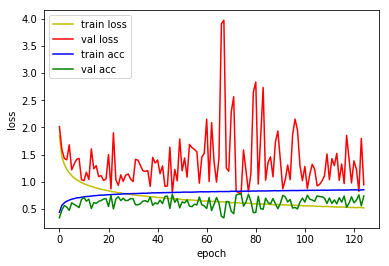

4815/4815 [==============================] - 3s 553us/sample - loss: 0.8653 - acc: 0.7337
Loss: 0.8652985211102019 Accuracy: 0.7337487

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6994 - acc: 0.4801
Epoch 00001: val_loss improved from inf to 1.74680, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_4_conv_checkpoint/001-1.7468.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.6994 - acc: 0.4801 - val_loss: 1.7468 - val_acc: 0.4687
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2802 - acc: 0.6187
Epoch 00002: val_loss improved from 1.74680 to 1.30801, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_4_conv_checkpoint/002-1.3080.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.2802 - acc: 0.6187 - val_loss: 1.3080 - val_acc: 0.5919
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.5868 - acc: 0.8323
Epoch 00027: val_loss did not improve from 0.75266
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5869 - acc: 0.8323 - val_loss: 0.8135 - val_acc: 0.7587
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5763 - acc: 0.8373
Epoch 00028: val_loss did not improve from 0.75266
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5764 - acc: 0.8372 - val_loss: 0.9084 - val_acc: 0.7289
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5731 - acc: 0.8343
Epoch 00029: val_loss did not improve from 0.75266
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.5735 - acc: 0.8342 - val_loss: 0.8974 - val_acc: 0.7216
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5644 - acc: 0.8372
Epoch 00030: val_loss improved from 0.75266 to 0.67530, saving model to model/checkpoint

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4239 - acc: 0.8796
Epoch 00056: val_loss did not improve from 0.64451
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4239 - acc: 0.8796 - val_loss: 0.9410 - val_acc: 0.7275
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4129 - acc: 0.8816
Epoch 00057: val_loss did not improve from 0.64451
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4129 - acc: 0.8816 - val_loss: 1.0764 - val_acc: 0.6816
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4146 - acc: 0.8818
Epoch 00058: val_loss did not improve from 0.64451
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.4149 - acc: 0.8818 - val_loss: 0.9267 - val_acc: 0.7230
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4087 - acc: 0.8825
Epoch 00059: val_loss improved from 0.64451 to 0.61841, saving model to mod

36800/36805 [============================>.] - ETA: 0s - loss: 0.3185 - acc: 0.9093
Epoch 00085: val_loss did not improve from 0.61841
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3186 - acc: 0.9093 - val_loss: 0.8270 - val_acc: 0.7689
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3242 - acc: 0.9087
Epoch 00086: val_loss did not improve from 0.61841
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3242 - acc: 0.9087 - val_loss: 0.7755 - val_acc: 0.7822
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3194 - acc: 0.9098
Epoch 00087: val_loss did not improve from 0.61841
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.3196 - acc: 0.9097 - val_loss: 0.8181 - val_acc: 0.7657
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3144 - acc: 0.9096
Epoch 00088: val_loss did not improve from 0.61841
36805/36805 [========================

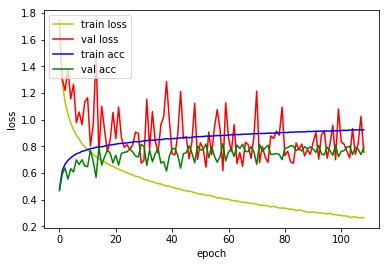

4815/4815 [==============================] - 3s 582us/sample - loss: 0.7107 - acc: 0.7956
Loss: 0.7106986285865246 Accuracy: 0.7956386

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5511 - acc: 0.5318
Epoch 00001: val_loss improved from inf to 1.85642, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_5_conv_checkpoint/001-1.8564.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 1.5511 - acc: 0.5317 - val_loss: 1.8564 - val_acc: 0.3704
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0454 - acc: 0.6983
Epoch 00002: val_loss improved from 1.85642 to 1.29965, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_5_conv_checkpoint/002-1.2996.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.0454 - acc: 0.6982 - val_loss: 1.2996 - val_acc: 0.5837
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.2585 - acc: 0.9273
Epoch 00025: val_loss did not improve from 0.40009
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2585 - acc: 0.9272 - val_loss: 0.4599 - val_acc: 0.8675
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2488 - acc: 0.9298
Epoch 00026: val_loss did not improve from 0.40009
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2490 - acc: 0.9297 - val_loss: 0.4203 - val_acc: 0.8798
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2462 - acc: 0.9318
Epoch 00027: val_loss did not improve from 0.40009
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.2462 - acc: 0.9318 - val_loss: 0.4553 - val_acc: 0.8682
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2332 - acc: 0.9349
Epoch 00028: val_loss did not improve from 0.40009
36805/36805 [========================

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9659
Epoch 00053: val_loss did not improve from 0.35408
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1262 - acc: 0.9659 - val_loss: 0.4609 - val_acc: 0.8737
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1190 - acc: 0.9692
Epoch 00054: val_loss did not improve from 0.35408
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1190 - acc: 0.9692 - val_loss: 0.3743 - val_acc: 0.9017
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1186 - acc: 0.9691
Epoch 00055: val_loss did not improve from 0.35408
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1186 - acc: 0.9691 - val_loss: 0.3807 - val_acc: 0.8940
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1155 - acc: 0.9701
Epoch 00056: val_loss did not improve from 0.35408
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0612 - acc: 0.9857
Epoch 00083: val_loss did not improve from 0.35408
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0612 - acc: 0.9857 - val_loss: 0.4400 - val_acc: 0.8859
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0617 - acc: 0.9849
Epoch 00084: val_loss did not improve from 0.35408
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0616 - acc: 0.9849 - val_loss: 0.4738 - val_acc: 0.8863
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0559 - acc: 0.9872
Epoch 00085: val_loss did not improve from 0.35408
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0561 - acc: 0.9872 - val_loss: 0.5838 - val_acc: 0.8619
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0657 - acc: 0.9838
Epoch 00086: val_loss did not improve from 0.35408
36805/36805 [===========

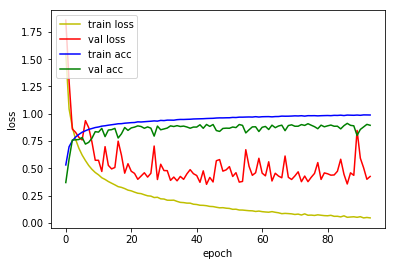

4815/4815 [==============================] - 3s 633us/sample - loss: 0.4003 - acc: 0.8804
Loss: 0.4003377884038388 Accuracy: 0.88037384

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3284 - acc: 0.6073
Epoch 00001: val_loss improved from inf to 1.45541, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_6_conv_checkpoint/001-1.4554.hdf5
36805/36805 [==============================] - 65s 2ms/sample - loss: 1.3283 - acc: 0.6073 - val_loss: 1.4554 - val_acc: 0.5572
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7301 - acc: 0.8006
Epoch 00002: val_loss improved from 1.45541 to 0.71465, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_6_conv_checkpoint/002-0.7147.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.7301 - acc: 0.8006 - val_loss: 0.7147 - val_acc: 0.7936
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0938 - acc: 0.9751
Epoch 00026: val_loss did not improve from 0.24394
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0938 - acc: 0.9751 - val_loss: 0.2881 - val_acc: 0.9241
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0868 - acc: 0.9769
Epoch 00027: val_loss did not improve from 0.24394
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0868 - acc: 0.9769 - val_loss: 0.2778 - val_acc: 0.9266
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0816 - acc: 0.9780
Epoch 00028: val_loss improved from 0.24394 to 0.22895, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_6_conv_checkpoint/028-0.2289.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0816 - acc: 0.9780 - val_loss: 0.2289 - val_acc: 0.9306
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0285 - acc: 0.9939
Epoch 00054: val_loss did not improve from 0.21763
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0285 - acc: 0.9938 - val_loss: 0.2468 - val_acc: 0.9418
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0277 - acc: 0.9936
Epoch 00055: val_loss did not improve from 0.21763
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0278 - acc: 0.9935 - val_loss: 0.2602 - val_acc: 0.9364
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0323 - acc: 0.9924
Epoch 00056: val_loss did not improve from 0.21763
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0323 - acc: 0.9924 - val_loss: 0.2283 - val_acc: 0.9422
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0187 - acc: 0.9966
Epoch 00057: val_loss did not improve from 0.21763
36805/36805 [========================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0090 - acc: 0.9985
Epoch 00084: val_loss did not improve from 0.21763
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0090 - acc: 0.9985 - val_loss: 0.3375 - val_acc: 0.9243
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0084 - acc: 0.9988
Epoch 00085: val_loss did not improve from 0.21763
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0084 - acc: 0.9988 - val_loss: 0.2653 - val_acc: 0.9427
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9978
Epoch 00086: val_loss did not improve from 0.21763
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0112 - acc: 0.9978 - val_loss: 0.2837 - val_acc: 0.9401
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9977
Epoch 00087: val_loss did not improve from 0.21763
36805/36805 [===========

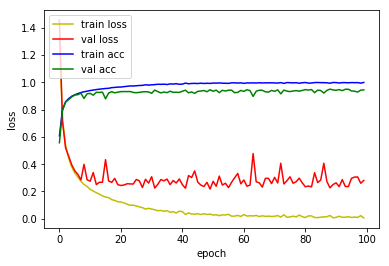

4815/4815 [==============================] - 3s 663us/sample - loss: 0.2719 - acc: 0.9281
Loss: 0.27192329813572474 Accuracy: 0.92814124

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1172 - acc: 0.6693
Epoch 00001: val_loss improved from inf to 1.01726, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_7_conv_checkpoint/001-1.0173.hdf5
36805/36805 [==============================] - 70s 2ms/sample - loss: 1.1171 - acc: 0.6693 - val_loss: 1.0173 - val_acc: 0.7156
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4998 - acc: 0.8626
Epoch 00002: val_loss improved from 1.01726 to 0.38810, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_7_conv_checkpoint/002-0.3881.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.4998 - acc: 0.8626 - val_loss: 0.3881 - val_acc: 0.8966
Epoch 3/500
36800/36805 [============================>.] - ETA: 0

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0337 - acc: 0.9926
Epoch 00027: val_loss improved from 0.17542 to 0.16677, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_7_conv_checkpoint/027-0.1668.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0337 - acc: 0.9926 - val_loss: 0.1668 - val_acc: 0.9562
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0242 - acc: 0.9956
Epoch 00028: val_loss did not improve from 0.16677
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0242 - acc: 0.9956 - val_loss: 0.1974 - val_acc: 0.9450
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0257 - acc: 0.9948
Epoch 00029: val_loss did not improve from 0.16677
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0257 - acc: 0.9948 - val_loss: 0.2261 - val_acc: 0.9448
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9974
Epoch 00056: val_loss did not improve from 0.16677
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0127 - acc: 0.9974 - val_loss: 0.1913 - val_acc: 0.9557
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0074 - acc: 0.9990
Epoch 00057: val_loss did not improve from 0.16677
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0074 - acc: 0.9990 - val_loss: 0.1891 - val_acc: 0.9539
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.16677
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0059 - acc: 0.9993 - val_loss: 0.2253 - val_acc: 0.9483
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0141 - acc: 0.9967
Epoch 00059: val_loss did not improve from 0.16677
36805/36805 [========================

Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9998
Epoch 00086: val_loss did not improve from 0.16281
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0025 - acc: 0.9998 - val_loss: 0.1668 - val_acc: 0.9606
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9990
Epoch 00087: val_loss did not improve from 0.16281
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0048 - acc: 0.9990 - val_loss: 0.1666 - val_acc: 0.9616
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9997
Epoch 00088: val_loss did not improve from 0.16281
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0026 - acc: 0.9997 - val_loss: 0.2262 - val_acc: 0.9518
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0071 - acc: 0.9984
Epoch 00089: val_loss did not improve from 0.16281
36805/36805 [===========

Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9996
Epoch 00116: val_loss did not improve from 0.16281
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0021 - acc: 0.9996 - val_loss: 0.1810 - val_acc: 0.9632

1D_CNN_custom_multi_2_GAP_BN_7_conv Model


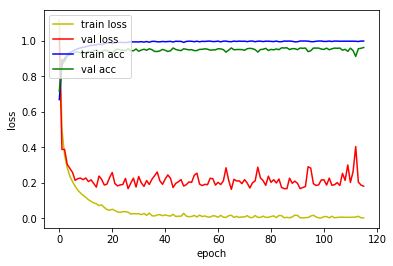

4815/4815 [==============================] - 3s 692us/sample - loss: 0.1985 - acc: 0.9493
Loss: 0.19854257594821115 Accuracy: 0.949325

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0323 - acc: 0.6876
Epoch 00001: val_loss improved from inf to 0.81100, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_8_conv_checkpoint/001-0.8110.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.0322 - acc: 0.6876 - val_loss: 0.8110 - val_acc: 0.7689
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4208 - acc: 0.8759
Epoch 00002: val_loss improved from 0.81100 to 0.34005, saving model to model/checkpoint/1D_CNN_custom_multi_2_GAP_BN_8_conv_checkpoint/002-0.3400.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.4207 - acc: 0.8759 - val_loss: 0.3400 - val_acc: 0.8991
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0290 - acc: 0.9923
Epoch 00028: val_loss did not improve from 0.16824
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0290 - acc: 0.9923 - val_loss: 0.1686 - val_acc: 0.9532
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9978
Epoch 00029: val_loss did not improve from 0.16824
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0112 - acc: 0.9977 - val_loss: 0.2012 - val_acc: 0.9488
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0216 - acc: 0.9946
Epoch 00030: val_loss did not improve from 0.16824
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0218 - acc: 0.9945 - val_loss: 0.2045 - val_acc: 0.9436
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9933
Epoch 00031: val_loss did not improve from 0.16824
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0115 - acc: 0.9968
Epoch 00057: val_loss did not improve from 0.16479
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0115 - acc: 0.9968 - val_loss: 0.2095 - val_acc: 0.9525
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9981
Epoch 00058: val_loss did not improve from 0.16479
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0088 - acc: 0.9981 - val_loss: 0.1935 - val_acc: 0.9539
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0162 - acc: 0.9953
Epoch 00059: val_loss did not improve from 0.16479
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0162 - acc: 0.9953 - val_loss: 0.2064 - val_acc: 0.9562
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9996
Epoch 00060: val_loss did not improve from 0.16479
36805/36805 [========================

Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0126 - acc: 0.9961
Epoch 00087: val_loss did not improve from 0.16479
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0126 - acc: 0.9961 - val_loss: 0.2146 - val_acc: 0.9539
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0026 - acc: 0.9995
Epoch 00088: val_loss did not improve from 0.16479
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0027 - acc: 0.9994 - val_loss: 0.1863 - val_acc: 0.9555
Epoch 89/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0106 - acc: 0.9969
Epoch 00089: val_loss did not improve from 0.16479
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0106 - acc: 0.9969 - val_loss: 0.1971 - val_acc: 0.9553
Epoch 90/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9993
Epoch 00090: val_loss did not improve from 0.16479
36805/36805 [===========

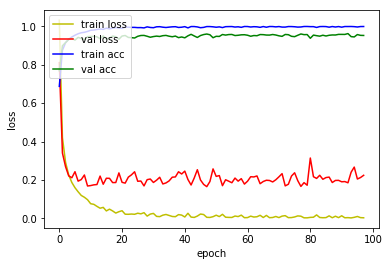

4815/4815 [==============================] - 4s 763us/sample - loss: 0.2102 - acc: 0.9470
Loss: 0.2101627866953209 Accuracy: 0.9470405



In [10]:
base = '1D_CNN_custom_multi_2_GAP_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_GAP_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 739us/sample - loss: 0.7107 - acc: 0.7956
Loss: 0.7106986285865246 Accuracy: 0.7956386

1D_CNN_custom_multi_2_GAP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)    

4815/4815 [==============================] - 4s 791us/sample - loss: 0.2719 - acc: 0.9281
Loss: 0.27192329813572474 Accuracy: 0.92814124

1D_CNN_custom_multi_2_GAP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)  

4815/4815 [==============================] - 4s 847us/sample - loss: 0.2102 - acc: 0.9470
Loss: 0.2101627866953209 Accuracy: 0.9470405


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_GAP_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
__________________________________________________________________

4815/4815 [==============================] - 4s 884us/sample - loss: 0.8275 - acc: 0.7674
Loss: 0.8274626008075345 Accuracy: 0.7673936

1D_CNN_custom_multi_2_GAP_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)    

4815/4815 [==============================] - 4s 901us/sample - loss: 0.2937 - acc: 0.9335
Loss: 0.29370298198852707 Accuracy: 0.933541

1D_CNN_custom_multi_2_GAP_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)    

4815/4815 [==============================] - 5s 965us/sample - loss: 0.2952 - acc: 0.9383
Loss: 0.2952482807042845 Accuracy: 0.9383178
